In [10]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import cv2 as cv

# Introduction

There are 2 objectives:

* View a few frames from random video files belonging to classes `REAL` and `FAKE`
* Build a Face detection + cropping algorithm that extracts all of the faces for us and crops them out from the original video frames.

In [146]:
DATA_FOLDER = '../input/deepfake-detection-challenge'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Train samples: {len(os.listdir(os.path.join(DATA_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_FOLDER, TEST_FOLDER)))}")

Train samples: 401
Test samples: 400


In [ ]:
FACE_DETECTION_FOLDER = '../input/haar-cascades-for-face-detection'
print(f"Face detection resources: {os.listdir(FACE_DETECTION_FOLDER)}")

## Let us first start by viewing a few images from classes `FAKE` and `REAL`

In [165]:
def display_first_frames_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER, title= "REAL"):
    plt.figure()
    fig, ax = plt.subplots(1,len(video_path_list),figsize=(25,8))
    fig.suptitle(title, fontsize = 25)
    # we only show images extracted from the first 6 videos
    
    frames = []
    for i, video_file in enumerate(video_path_list):
        video_path = os.path.join(DATA_FOLDER, video_folder,video_file)
        capture_image = cv.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        

        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        frames.append(frame)
        ax[i].imshow(frame)
        ax[i].set_title(f"Video: {video_file}", fontsize = 20)
        ax[i].axis('on')
        
    return frames

<Figure size 432x288 with 0 Axes>

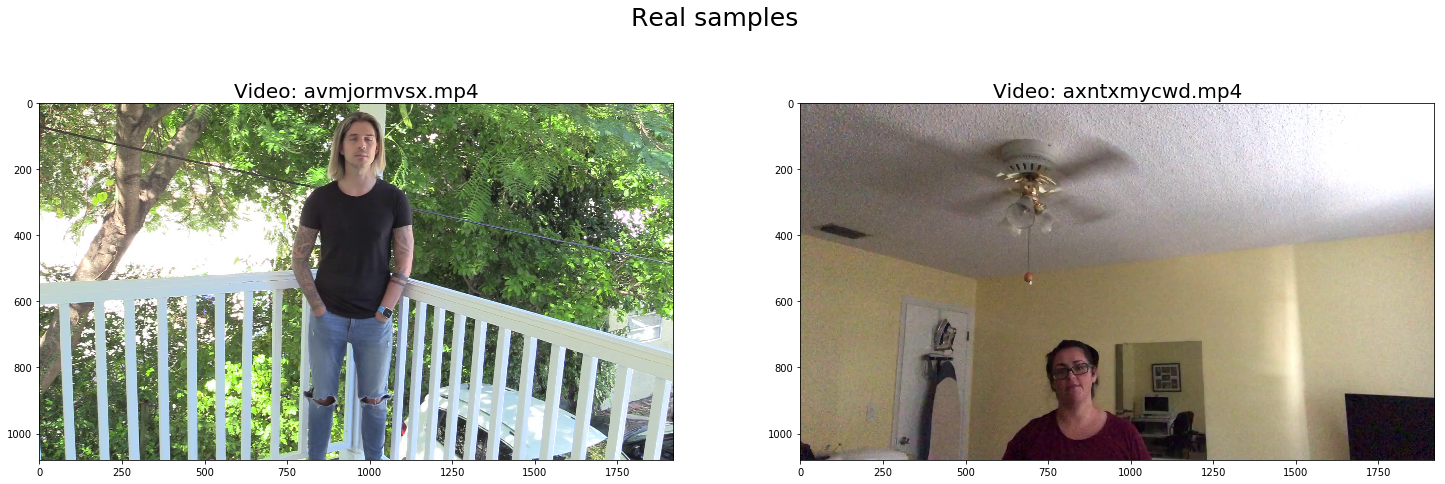

In [166]:
real_video_filenames = list(meta_train_df.loc[meta_train_df.label=='REAL'].index)
_ = display_first_frames_from_video_list(real_video_filenames[10:12],  title= "Real samples")

<Figure size 432x288 with 0 Axes>

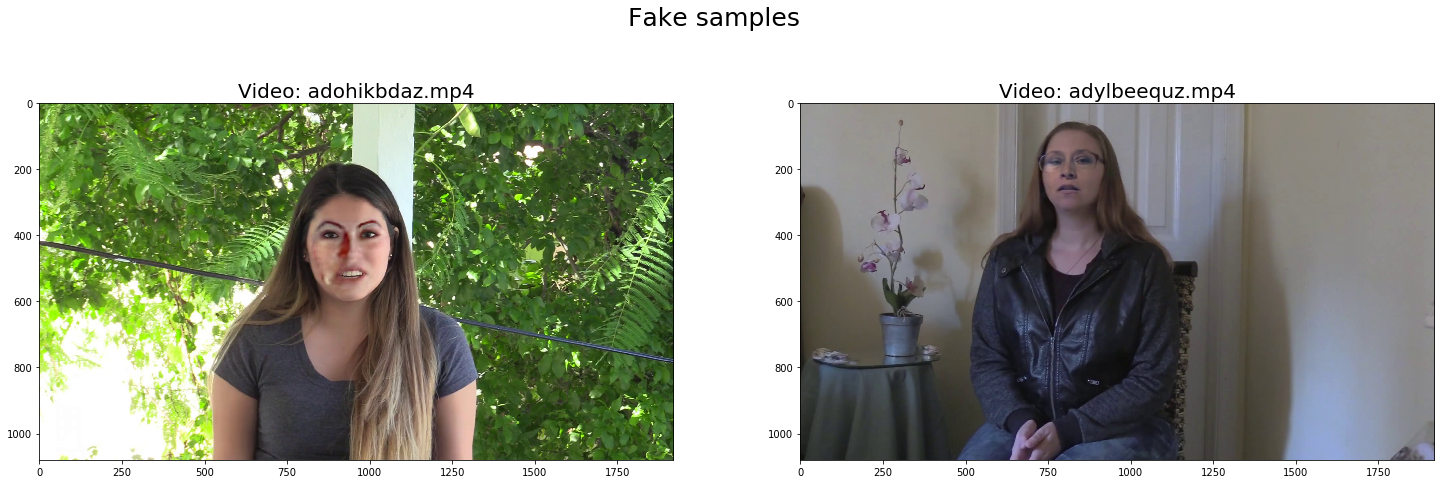

In [167]:
fake_video_filenames = list(meta_train_df.loc[meta_train_df.label=='FAKE'].index)
frames = display_first_frames_from_video_list(fake_video_filenames[10:12], title = "Fake samples")

# Extracting Facial Landmarks 

In [162]:
!pip install face_recognition

Found 1 face(s) in this photograph.
A face is located at pixel location Top: 320, Left: 795, Bottom: 587, Right: 1062


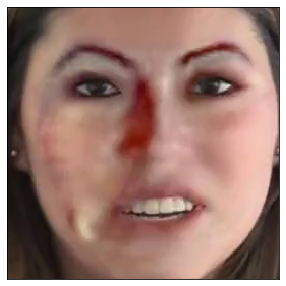

In [168]:
import face_recognition

frame = frames[0]
face_locations = face_recognition.face_locations(frame)

# https://github.com/ageitgey/face_recognition/blob/master/examples/find_faces_in_picture.py
from PIL import Image

print("Found {} face(s) in this photograph.".format(len(face_locations)))

for face_location in face_locations:

    # Print the location of each face in this image
    top, right, bottom, left = face_location
    print("A face is located at pixel location Top: {}, Left: {}, Bottom: {}, Right: {}".format(top, left, bottom, right))

    # You can access the actual face itself like this:
    face_image = frame[top:bottom, left:right]
    fig, ax = plt.subplots(1,1, figsize=(5, 5))
    plt.grid(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.imshow(face_image)

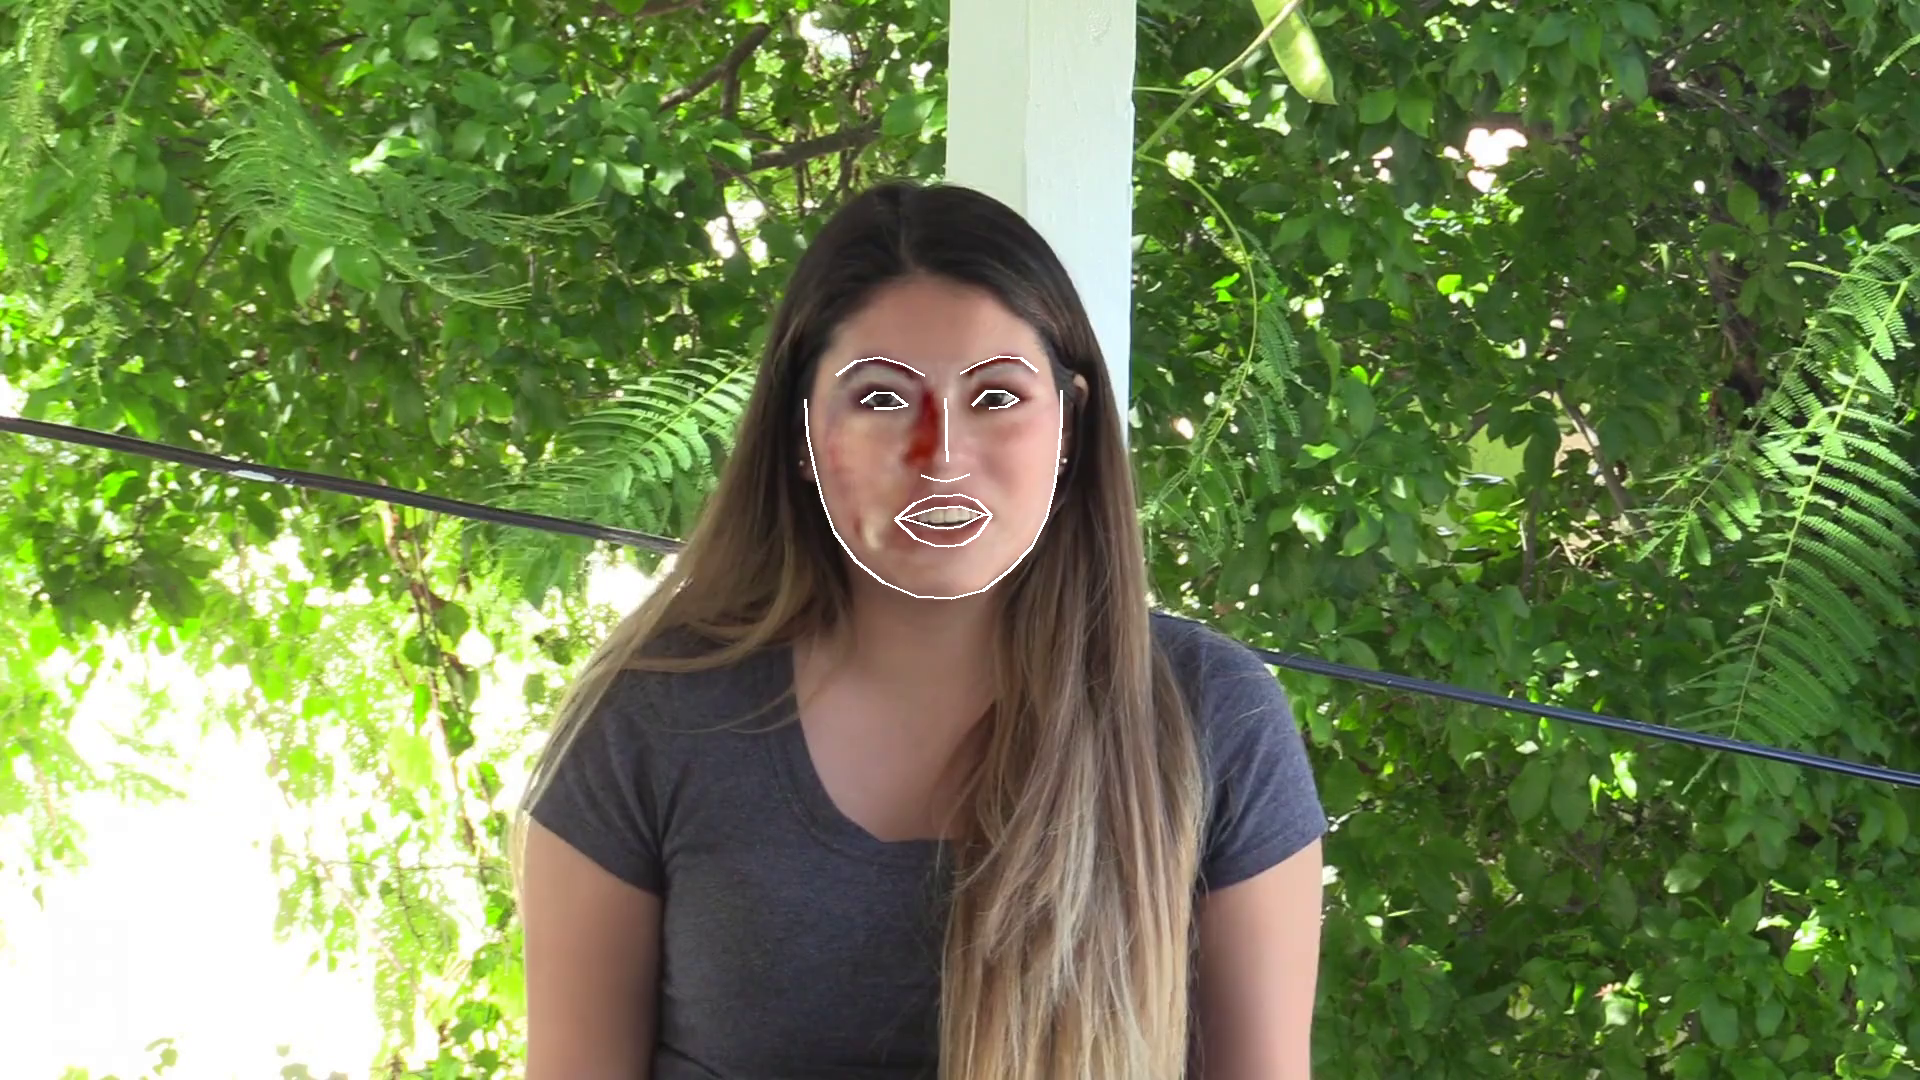

In [127]:
image = frame
face_landmarks_list = face_recognition.face_landmarks(image)
from PIL import Image, ImageDraw
pil_image = Image.fromarray(image)
d = ImageDraw.Draw(pil_image)

for face_landmarks in face_landmarks_list:
    # Let's trace out each facial feature in the image with a line!
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=3)

# Show the picture
display(pil_image)

The number of frames saved:  300


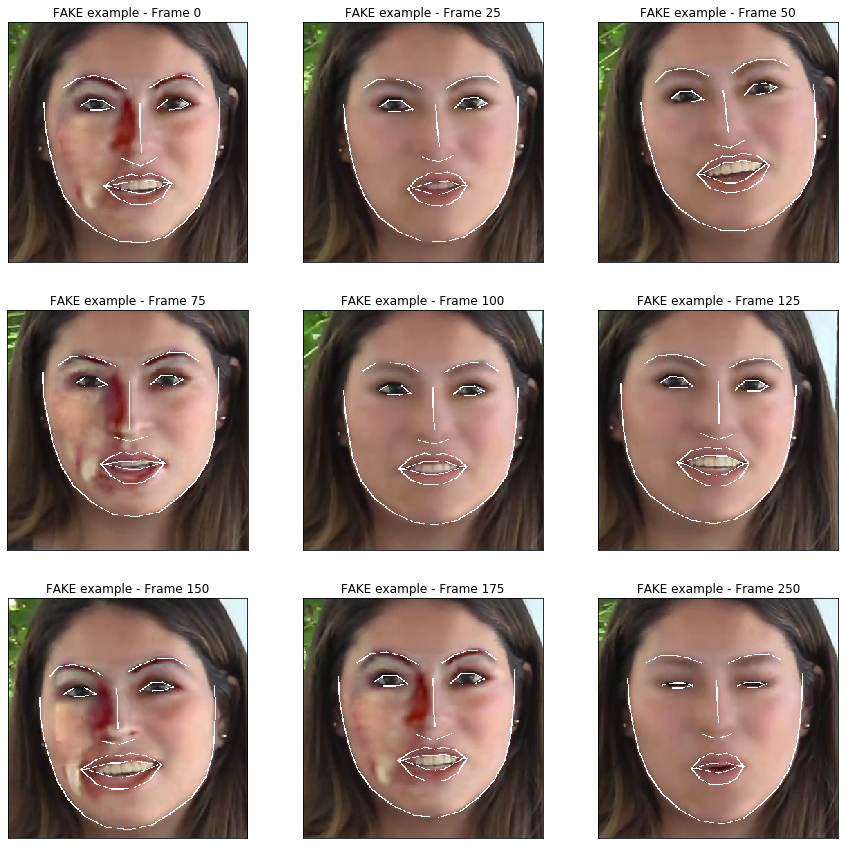

In [131]:
fn = fake_video_filenames[10]
video_file = f'/kaggle/input/deepfake-detection-challenge/train_sample_videos/{fn}'

cap = cv2.VideoCapture(video_file)

frames = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frames.append(frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
cap.release()

print('The number of frames saved: ', len(frames))

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = np.array(axes)
axes = axes.reshape(-1)
ax_ix = 0
padding = 40
for i in [0, 25, 50, 75, 100, 125, 150, 175, 250, 275]:
    frame = frames[i]
    #fig, ax = plt.subplots(1,1, figsize=(5, 5))
    face_locations = face_recognition.face_locations(frame)
    if len(face_locations) == 0:
        print(f'Count find face in frame {i}')
        continue
    top, right, bottom, left = face_locations[0]
    frame_face = frame[top-padding:bottom+padding, left-padding:right+padding]
    face_landmarks_list = face_recognition.face_landmarks(frame_face)
    if len(face_landmarks_list) == 0:
        print(f'Could not identify face landmarks for frame {i}')
        continue
    face_landmarks = face_landmarks_list[0]
    pil_image = Image.fromarray(frame_face)
    d = ImageDraw.Draw(pil_image)
    for facial_feature in face_landmarks.keys():
        d.line(face_landmarks[facial_feature], width=2, fill='white')
    landmark_face_array = np.array(pil_image)
    image = cv.cvtColor(landmark_face_array, cv.COLOR_BGR2RGB)
    axes[ax_ix].imshow(image)
    axes[ax_ix].grid(False)
    axes[ax_ix].set_title(f'FAKE example - Frame {i}')
    axes[ax_ix].xaxis.set_visible(False)
    axes[ax_ix].yaxis.set_visible(False)
    ax_ix += 1
    if ax_ix >= len(axes):
        break
plt.grid(False)
plt.show()

# Extracting Faces 

In [133]:
TRAIN_DIR = '/kaggle/input/deepfake-detection-challenge/train_sample_videos/'
TMP_DIR = '/kaggle/tmp/'
ZIP_NAME = 'dfdc_train_faces_sample.zip'
METADATA_PATH = TRAIN_DIR + 'metadata.json'


In [139]:
import json
import pandas as pd

with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

In [138]:
train_df = pd.DataFrame(
    [
        (video_file, metadata[video_file]['label'], metadata[video_file]['split'], metadata[video_file]['original'] if 'original' in metadata[video_file].keys() else '')
        for video_file in metadata.keys()
    ],
    columns=['filename', 'label', 'split', 'original']
)

train_df.head()

filename label  split        original
0  aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
1  aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
2  abarnvbtwb.mp4  REAL  train            None
3  abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
4  abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4

In [ ]:
!pip install facenet-pytorch

In [151]:
from facenet_pytorch import MTCNN
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=DEVICE).eval()

# Define face extractor
face_extractor = FaceExtractor(detector=face_detector, n_frames=None, resize= 0.25)

In [152]:
class FaceExtractor:
    def __init__(self, detector, n_frames=None, resize=None):
        """
        Parameters:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """

        self.detector = detector
        self.n_frames = n_frames
        self.resize = resize
    
    def __call__(self, filename, save_dir):
        """Load frames from an MP4 video, detect faces and save the results.

        Parameters:
            filename {str} -- Path to video.
            save_dir {str} -- The directory where results are saved.
        """

        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)
                
                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])

                save_path = os.path.join(save_dir, f'{j}.png')

                self.detector([frame], save_path=save_path)

        v_cap.release()

In [161]:
all_train_videos = glob.glob(os.path.join(TRAIN_DIR, '*.mp4'))

In [154]:
!mkdir -p $TMP_DIR

In [158]:
with torch.no_grad():
    for path in all_train_videos:
        file_name = path.split('/')[-1]

        save_dir = os.path.join(TMP_DIR, file_name.split(".")[0])

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Detect all faces appear in the video and save them.
        face_extractor(path, save_dir)

In [159]:
train_df.to_csv('metadata.csv', index=False)

## Zipping it all together

In [ ]:
!apt install zip > /dev/null 2>&1

In [ ]:
ZIP_NAME = 'dfdc_train_faces_sample.zip'
!zip -r -m -q /kaggle/working/$ZIP_NAME *